In [194]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import yaml_load

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
from helper_fns import spawn_models
from mpc import MPC

mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])

q0 = np.ones(7)
dq0 = 0.03*np.ones(7)

params = {'q': q0,
          'dq': dq0,
          'belief_free':1.0,
          'belief_point':0.0,
          'imp_stiff':400*ca.DM.ones(3),}

In [201]:
# MPC only, i.e. without iCEM warmstart
mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options['ipopt.print_level'] = 0
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options)

params['belief_free'] = 1.0
params['belief_point'] = 0.0

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost_free, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost_point, res_point = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}")
print(f"Free space: {t_mpc_free_warm}, {cost_free} \n     Point: {t_mpc_point}, {cost_point}")
res['imp_stiff'] = params['imp_stiff']
traj_mpc = robots['point'].get_ext_state(res2)
#print(traj_mpc['contact_1/F'][0,:])
#print(traj_mpc['F_imp'])
print(traj_mpc['imp_rest'])

Adding contact setpoint cost for contact_1/F
Free space cold 1.575197458267212, Free space warm 0.024842023849487305, Point: 0.056403160095214844
Free space: 0.024842023849487305, 3.64373 
     Point: 0.056403160095214844, 4.12133
[[ 1.5         0.87732543 -0.88780596 -0.18248556  0.17236108  0.24552401
   0.24308874  0.23786896  0.24017938  0.24733809  0.25681693  0.26733042
   0.27822443  0.28913288  0.29986164  0.31034965  0.32062052  0.33038847
   0.33694183  0.32884621]
 [ 0.30036947  0.56281381  0.65987102  0.58181149  0.51879491  0.47516181
   0.43762727  0.40405392  0.37481865  0.35023852  0.33024782  0.31442666
   0.30212095  0.2925696   0.28500331  0.27871354  0.2731359   0.26820621
   0.26613233  0.27795176]
 [-0.5938341   0.65662441  1.24726462  0.91914405  0.71426953  0.67049341
   0.67370513  0.68205974  0.68894331  0.6950251   0.70098889  0.70699415
   0.71304682  0.71917411  0.7254444   0.7319318   0.73866313  0.7456006
   0.75276276  0.75969257]]


In [202]:
# iCEM-only result
mpc_params['num_iter'] = 30
mpc.icem_init()

params['belief_free'] = 1.0
params['belief_point'] = 0.0
time_cem_free, cost_free, res = timed_exec(mpc.icem_solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0
time_cem_point, cost_point, res = timed_exec(mpc.icem_solve, params)
print(f"Free space: {time_cem_free}, {cost_free} \n     Point: {time_cem_point}, {cost_point}")
traj_cem = robots['point'].get_ext_state(res)
print(traj_cem['imp_rest'])

Free space: 0.718700647354126, 4.3215 
     Point: 0.5262908935546875, 4.56696
[[ 0.17598983 -0.13761855 -0.40551896 -0.51974937 -0.49568548 -0.36330456
  -0.21393903 -0.17943147 -0.16479123 -0.15858241 -0.07436233 -0.08296337
  -0.21266007 -0.31995624 -0.35782013 -0.30847822 -0.13659694 -0.00151647
   0.18176194  0.32850986]
 [ 0.09139195  0.01458154  0.04926118  0.23373895  0.20722084  0.17221014
   0.19915281  0.1459173   0.11048668 -0.02413177 -0.06494846  0.13061037
   0.30581998  0.33175754  0.40967864  0.42846405  0.36399185  0.32518287
   0.28305079  0.19377518]
 [ 0.53019771  0.3748354   0.24167763  0.21811525  0.20535907  0.27832353
   0.28815722  0.39931613  0.38155418  0.36045214  0.44895068  0.386066
   0.37970626  0.44957713  0.51358769  0.73024392  1.10352026  1.37550336
   1.1994642   0.76048153]]


In [207]:
iters = [0, 1, 2, 3, 4]
N = 15
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options, icem=False)
iter_times_mean = []
iter_times_std = []
iter_cost_mean = []
iter_cost_std = []
for n_iter in iters:
    times = []
    costs = []
    for _ in range(N):
        mpc.icem_init()
        params['belief_free'] = 1.0
        params['belief_point'] = 0.0 
        mpc.solve(params)
        
        params['belief_free'] = 0.0
        params['belief_point'] = 1.0
        params['q'] = 0.005*np.random.randn(7) # perturb initial state
        params['dq'] = 0.01*np.random.randn(7) # perturb initial state
        tic = time.perf_counter()
        if n_iter > 0: mpc.icem_warmstart(params, num_iter=n_iter)
        cost, _ = mpc.solve(params)
        times.append(time.perf_counter()-tic)
        costs.append(np.squeeze(cost.full()))
    iter_times_mean.append(np.mean(times))
    iter_times_std.append(np.std(times))
    iter_cost_mean.append(np.mean(costs))
    iter_cost_std.append(np.std(costs))

Adding contact setpoint cost for contact_1/F


Text(0, 0.5, 'Solve time')

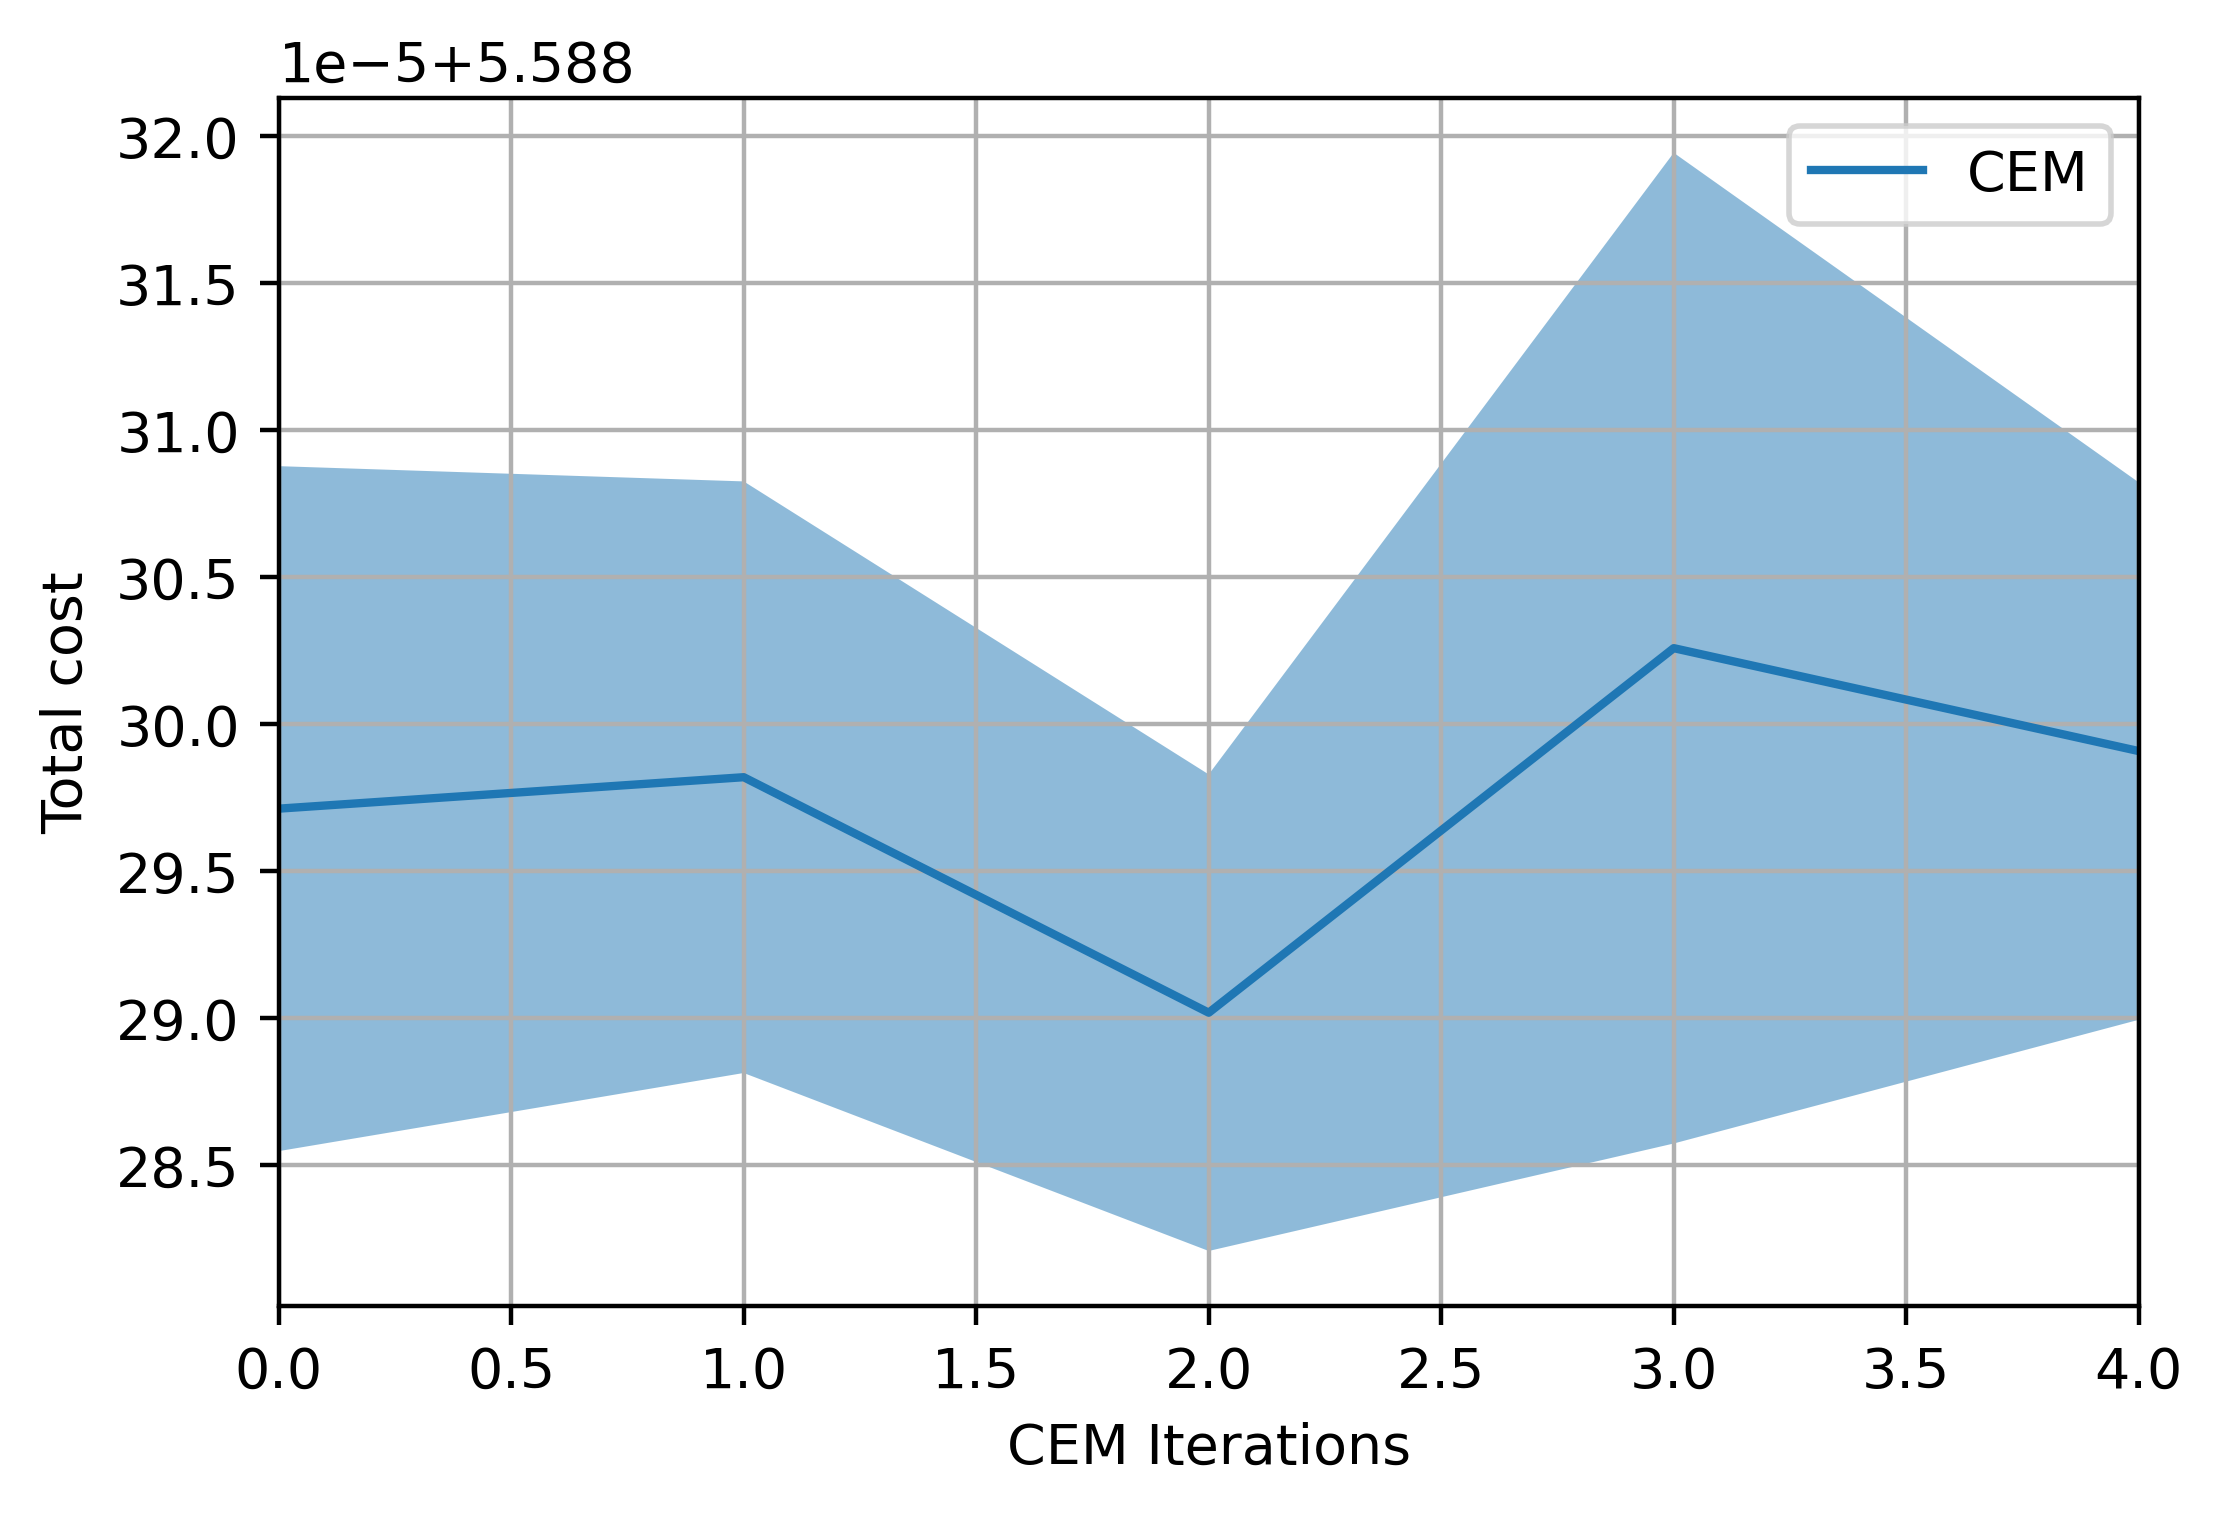

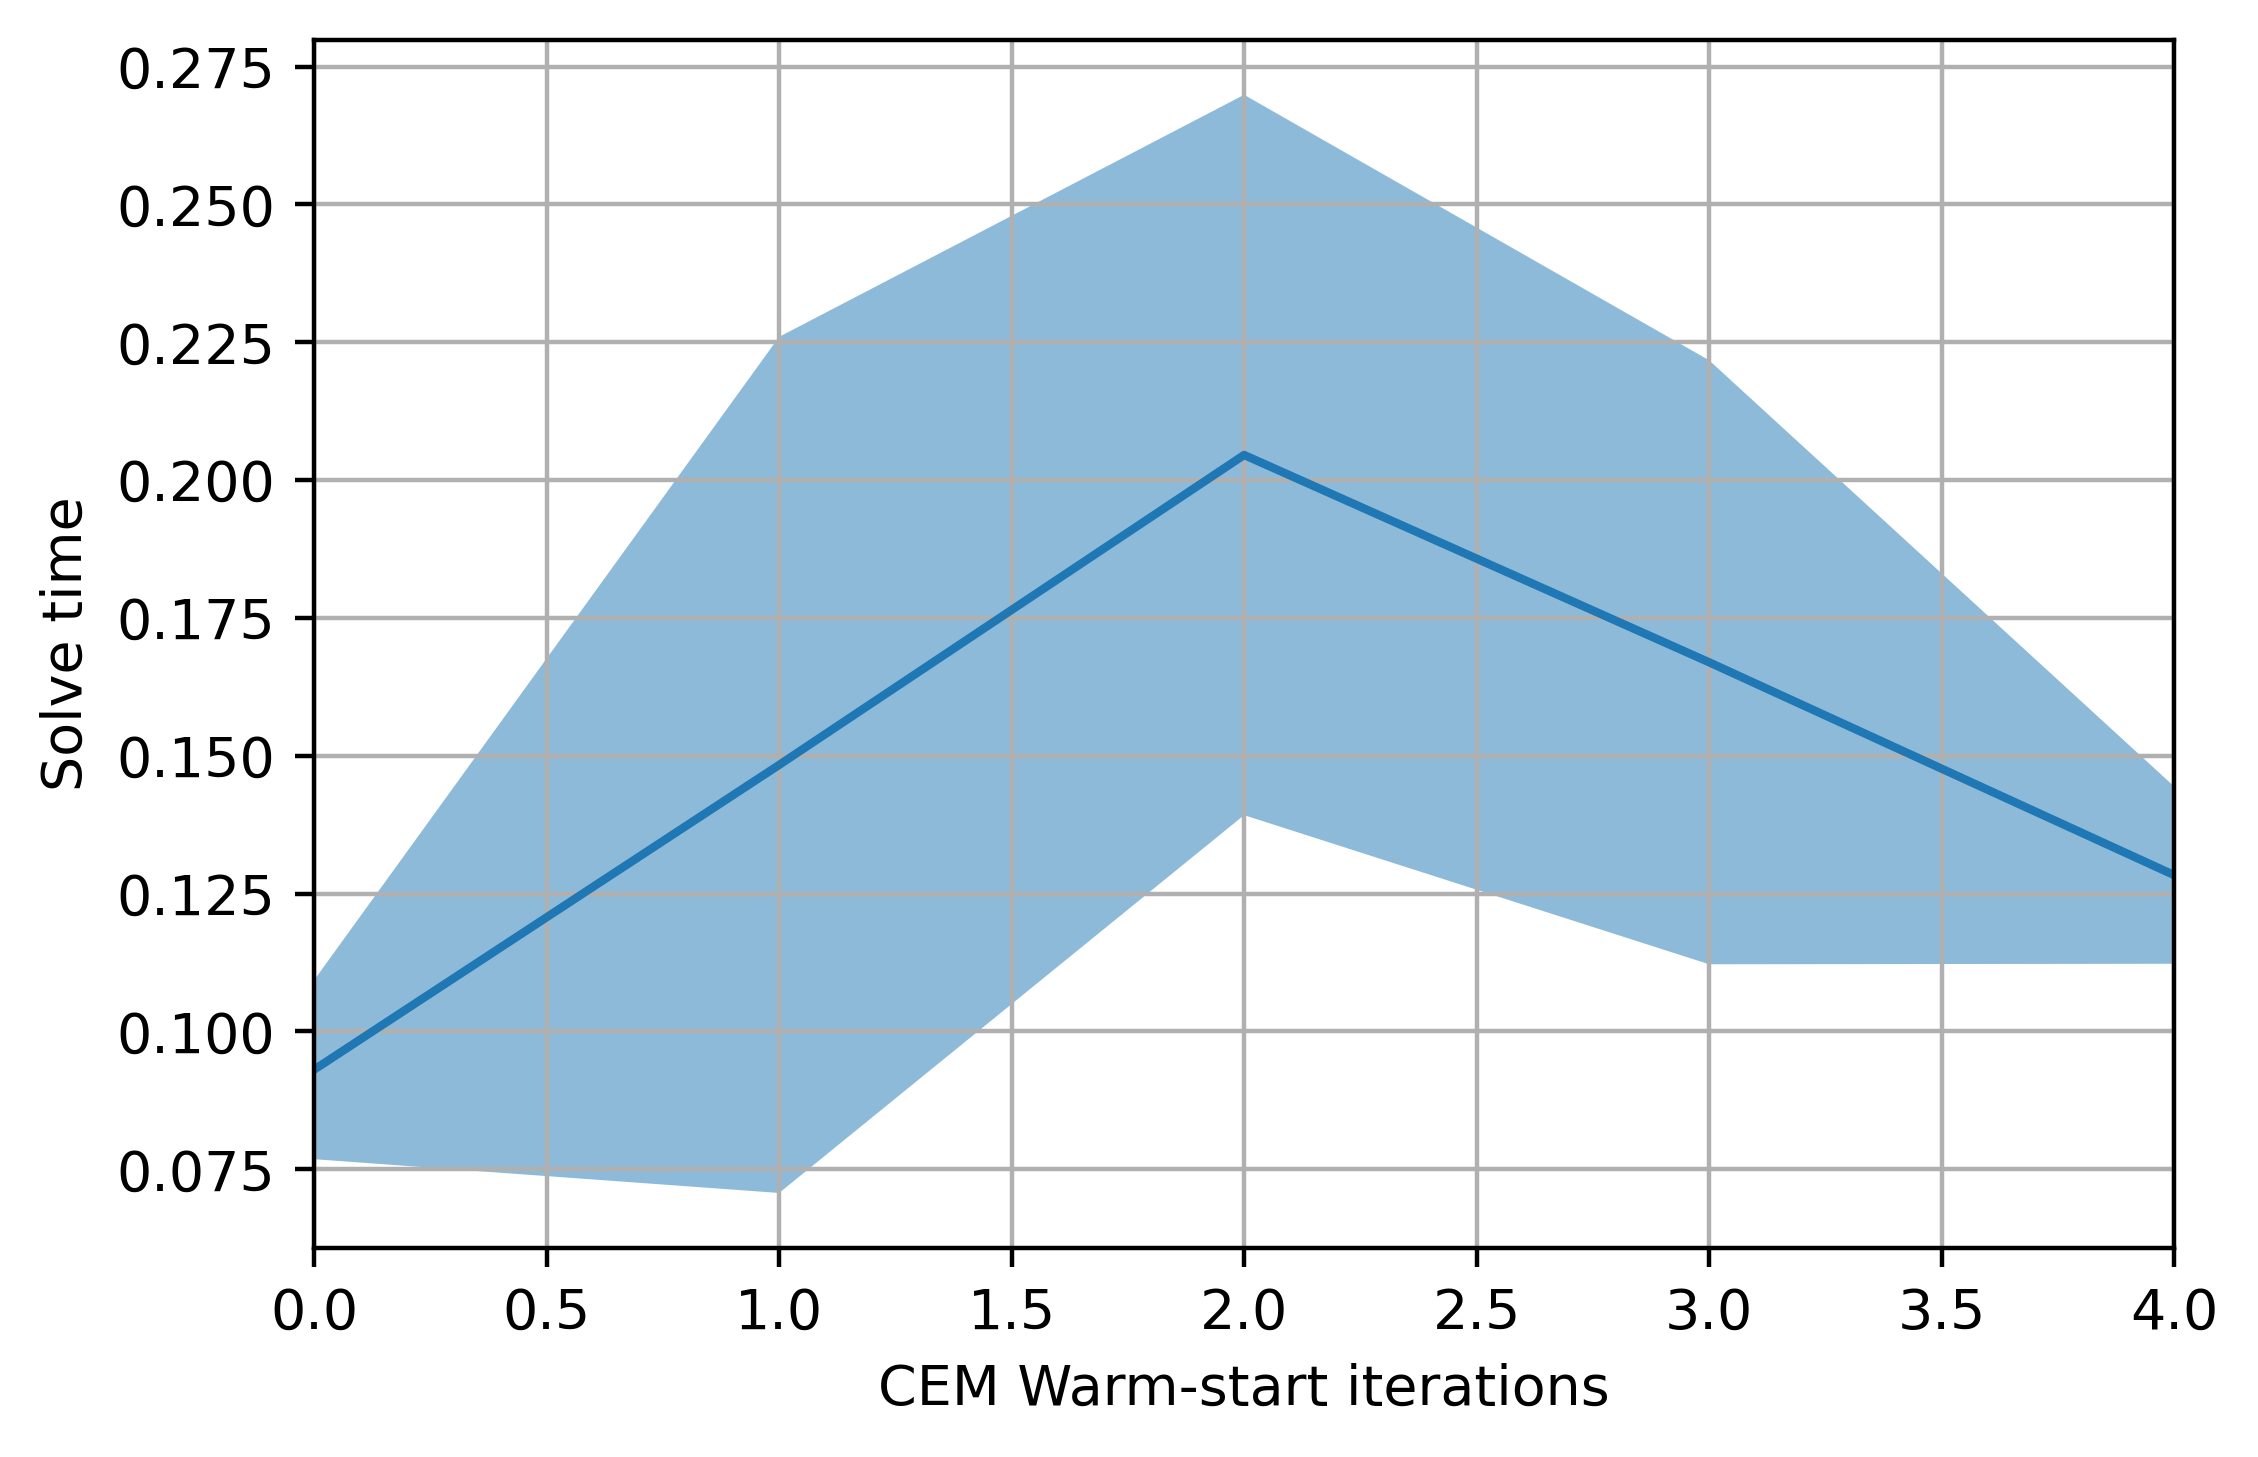

In [208]:
plt.plot(iters, iter_cost_mean, label='CEM')
mu = np.array(iter_cost_mean)
sig = np.array(iter_cost_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)

plt.legend()
plt.xlim(0,iters[-1])
plt.xlabel('CEM Iterations')
plt.ylabel('Total cost')


plt.figure()
plt.plot(iters, iter_times_mean)
mu = np.array(iter_times_mean)
sig = np.array(iter_times_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)
plt.xlim(0,iters[-1])
plt.xlabel('CEM Warm-start iterations')
plt.ylabel('Solve time')
#plt.savefig('cem_warmstart_num_iter.pdf')

In [205]:
# Increasing stiffness

In [193]:
# Increasing planning horizon